# Part 1: Launching a Duet Server

In [1]:
import syft as sy
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


# Part 2: Search for data

In [2]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 7f8bebefea6449b190099da8e2435d67>,[iris-data],This is a dataset for the classification of fl...,<class 'torch.Tensor'>
1,<UID: 38f7a0c80e894ce3a6ff2260b62db22f>,[iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

In [5]:
print(data_ptr)
print(target_ptr)

# Part 3: Performing Logistic Regression on Iris Dataset

In [6]:
print(duet.store.pandas["Description"][0])

This is a dataset for the classification of flowers of 150 samples with 4 features: sepal length, sepal width, petal length, petal width all in cm


In [7]:
print(duet.store.pandas["Description"][1])

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


# Train Model

In [8]:
import torch

In [14]:
in_dim = 4
out_dim = 3
n_sample = 150

In [15]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


In [18]:
local_model = SyNet(torch)

In [19]:
remote_model = local_model.send(duet)

In [20]:
remote_torch = duet.torch

In [21]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params = params, lr=0.01)
print("params:", params)
print("optim:", optim)

params: <syft.proxy.syft.lib.python.ListPointer object at 0x00000251089F47C0>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x0000025151AFE730>


In [32]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        # nll_loss = negative log-liklihood loss
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

In [33]:
iteration = 60
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 0.07272499799728394
Epoch 10 loss 0.061898842453956604
Epoch 20 loss 0.05713148042559624
Epoch 30 loss 0.05443151295185089
Epoch 40 loss 0.05265791714191437
Epoch 50 loss 0.051336947828531265


Text(0.5, 0, 'iteration')

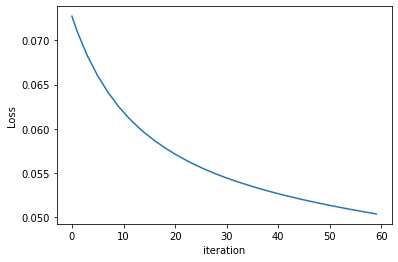

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

# Download model

In [35]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

# Test on local data

In [36]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [37]:
iris_test = pd.read_csv("./data/iris-test.csv")
iris_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.0,2.7,5.1,1.6,1
3,6.0,2.9,4.5,1.5,1
4,5.8,2.7,5.1,1.9,2


In [38]:
X_test = iris_test.loc[:, iris_test.columns != "species"]
y_test = iris_test["species"]

In [39]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [42]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2


In [43]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 93.33333333333333
